In [50]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [51]:
#database connection settings
import psycopg2

db_name = "traviato_development"
db_host = "localhost"
db_port = "5432"
db_user = "lievgarcia"
db_pwd = "traviato81"

conn = psycopg2.connect(database=db_name, user=db_user, password=db_pwd, host=db_host, port=db_port)

In [52]:
######################## libraries ########################

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np

import sys
sys.path.append('../../')

from utils.utility_functions import label_top
from utils.utility_functions import get_last_name
from utils.utility_functions import make_dash_zero

##################### CHARTING OPTIONS #####################

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})

rc('text', usetex=True)
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']


##################### SOURCES OPTIONS #####################

archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper', 
                    'Chicago Lyric Opera','San Francisco Opera','Czech National Theatre','Glyndebourne','Salzburg Festival',
                    'Sweden Opera House','National Opera de Paris','Opera Comique']
commercial_sources_world = ['bachtrack.com','operabase.com','operacritic.com']
commercial_sources_uk = ['Concert-Diary','U.K. Theatre Web']
government_sources = ['National Central Opera Service Reports', 'Opera America']

##############################################################################

In [53]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 'date_start', 'date_end', 'premiere_date', 'performance_count']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "ORDER BY s.id, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)

In [4]:
######################## data sources overview table ########################
import numpy as np
import datetime

mdf.head()
o_df = mdf.groupby(['source_name'])

o_df = o_df.agg({'performance_count': np.sum , 
              'date_start': np.min ,
              'date_end': np.max })

for idx,row in o_df.iterrows():
    print(row.name + ' & ' + row['date_start'].strftime('%Y') + ' & ' + row['date_end'].strftime('%Y') + ' & ' + str(row['performance_count']) + " \\\\")
#     print('{} show times between {} and {}'.format(row['performance_count'], row['date_start'].strftime('%Y')), row['date_end'].strftime('%Y'))
#     print('{}: \\numprint{} showtimes between {} and {}'.format(row.name, row['performance_count'], row['date_start'].strftime('%Y'), row['date_end'].strftime('%Y')))    
    
##############################################################################

AusStage & 1950 & 2018 & 3081 \\
Chicago Lyric Opera & 1954 & 2012 & 2818 \\
Concert-Diary & 2000 & 2018 & 10915 \\
Czech National Theatre & 1881 & 2018 & 42068 \\
Glyndebourne & 1934 & 2017 & 7362 \\
Metropolitan Opera & 1883 & 2018 & 28769 \\
National Central Opera Service Reports & 1955 & 1990 & 196065 \\
National Opera de Paris & 1972 & 2016 & 6627 \\
Opera America & 1991 & 2020 & 49115 \\
Opera Comique & 1764 & 2018 & 10505 \\
Opera Scotland & 1956 & 2019 & 10975 \\
Royal Opera House & 1946 & 2012 & 4669 \\
Salzburg Festival & 1921 & 2017 & 3253 \\
San Francisco Opera & 1923 & 2018 & 5996 \\
Sweden Opera House & 1773 & 2018 & 40291 \\
Teatro alla Scala & 1949 & 2017 & 8674 \\
U.K. Theatre Web & 1996 & 2018 & 40467 \\
Wiener Staatsoper & 1869 & 2018 & 31306 \\
bachtrack.com & 2017 & 2019 & 5483 \\
operabase.com & 2011 & 2019 & 151374 \\
operacritic.com & 2007 & 2019 & 103749 \\


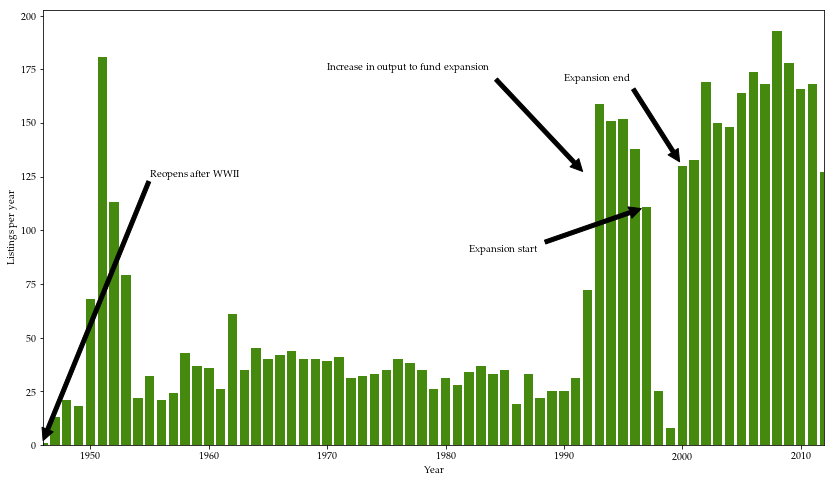

In [6]:
######################## SINGLE THEATRE FOCUS (ROH) ########################

sources = ['Royal Opera House']

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
# o_df = o_df[o_df['work'] != 'Unknown']
# o_df = o_df[(o_df['year'] > 1940) & (o_df['year'] < 2013)]
o_df = o_df.groupby(['source_name', 'year'])
o_df = o_df.agg({'performance_count': np.sum })
o_df = o_df.reset_index(level=['year'])

###############################################################

##################### CHART BUILDING OPTIONS #####################

sources = o_df.index.get_level_values('source_name').get_values()
sources = list(set(sources))

fig, ax = plt.subplots(figsize=(14, 8))

for source in sources:
    dat = o_df.loc[source]
#     dates = dat.index
    dates = dat['year'].values
    
    left_edge = dat['year'].values[0]
    right_edge = dat['year'].values[-1]    
    ax.bar(dates, dat['performance_count'], label=source, color='#458a0f', linewidth=3)
    ax.set_xlim(left_edge, right_edge)
    ax.annotate('Reopens after WWII', xy=(1946, 2), xytext=(1955, 125), arrowprops=dict(facecolor='black', shrink=1), )    
    ax.annotate('Increase in output to fund expansion', xy=(1992, 125), xytext=(1970, 175), arrowprops=dict(facecolor='black', shrink=0.05), )                
    ax.annotate('Expansion start', xy=(1997, 111), xytext=(1982, 90), arrowprops=dict(facecolor='black', shrink=0.05), )            
    ax.annotate('Expansion end', xy=(2000, 130), xytext=(1990, 170), arrowprops=dict(facecolor='black', shrink=0.05), )        


plt.xlabel("Year")
plt.ylabel("Listings per year")

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.grid(False)

###############################################################

In [7]:
######################## top composers ########################
sources = archival_sources

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

for num, source in enumerate(sources):
    c_df = o_df[o_df['source_name']==source]
    c_df = c_df.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    c_df = c_df.head(5)
    c_df = c_df.reset_index(level=['composer'])  
    c_df[source] = c_df['composer']    
    c_df = c_df[source]
    if num==0:
        df = c_df.copy().to_frame()
    else:
        df = df.join(c_df, how='outer')
    
#If displaying sources as columns
# print('\\textbf{Ranking} & \\textbf{' + ' & \\textbf{'.join(df.columns.values.tolist()) + ' \\\ \midrule ')

# for idx,row in df.iterrows():
#     print(str(idx+1) + ' & ' + ' & '.join(row.values.tolist()) + " \\\\")

df = df.T

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [get_last_name(c) for c in values ]
    print(idx + ' & ' + ' & '.join(values) + " \\\\")
###############################################################

Metropolitan Opera & Verdi & Puccini & Wagner & Mozart & Donizetti \\
Opera Scotland & Mozart & Verdi & Puccini & Rossini & Donizetti \\
Royal Opera House & Verdi & Puccini & Mozart & Wagner & Strauss \\
Teatro alla Scala & Verdi & Puccini & Donizetti & Rossini & Mozart \\
Wiener Staatsoper & Verdi & Mozart & Wagner & Puccini & Strauss \\
Chicago Lyric Opera & Verdi & Puccini & Wagner & Mozart & Donizetti \\
San Francisco Opera & Verdi & Puccini & Wagner & Mozart & Donizetti \\
Czech National Theatre & Smetana & Dvořák & Mozart & Verdi & Puccini \\
Glyndebourne & Mozart & Verdi & Rossini & Strauss & Britten \\
Salzburg Festival & Mozart & Strauss & Verdi & Beethoven & Rossini \\
Sweden Opera House & Verdi & Mozart & Puccini & Wagner & Bizet \\
National Opera de Paris & Verdi & Mozart & Puccini & Rossini & Strauss \\
Opera Comique & Gounod & Donizetti & Offenbach & Isouard & Dalayrac \\


In [8]:
######################## top composers table ########################

sources = archival_sources

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

top_composers = []

for num, source in enumerate(sources):
    c_df = o_df[o_df['source_name']==source]
    c_df = c_df.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    top = c_df.head(5)
    for composer in list(top.index):
        if composer not in top_composers:
            top_composers.append(composer) 
    c_df = c_df.reset_index(level=['composer'])  
    c_df.index += 1
    c_df = c_df.reset_index() 
    c_df = c_df.rename({'index': source}, axis='columns')
    c_df = c_df.set_index('composer')
    c_df = c_df[[source]]
    if num==0:
        df = c_df.copy()
    else:
        df = df.join(c_df, how='outer')

df = df.reset_index(level=['composer'])  
df = df[df['composer'].isin(top_composers)]  
df = df.fillna(value=0)

decades = df.columns.get_values().tolist()
decades = [str(d) for d in decades[1:]]
o_df = o_df.fillna(value=0)


print('r'*len(decades))
print('\\textbf{Composer} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values[1:] ]
    print(get_last_name(row['composer']) + ' & ' + ' & '.join(values) + " \\\\")

rrrrrrrrrrrrr
\textbf{Composer} & \textbf{Metropolitan Opera & \textbf{Opera Scotland & \textbf{Royal Opera House & \textbf{Teatro alla Scala & \textbf{Wiener Staatsoper & \textbf{Chicago Lyric Opera & \textbf{San Francisco Opera & \textbf{Czech National Theatre & \textbf{Glyndebourne & \textbf{Salzburg Festival & \textbf{Sweden Opera House & \textbf{National Opera de Paris & \textbf{Opera Comique \\ \midrule 
Dvořák & 50 & 43 & 51 & 43 & 88 & - & 73 & 2 & 23 & 55 & - & 35 & - \\
Smetana & 31 & 25 & 27 & - & 13 & 47 & 44 & 1 & 25 & - & 71 & 44 & - \\
Britten & 24 & 7 & 7 & 19 & 49 & 13 & 15 & 58 & 5 & 72 & 33 & 22 & 91 \\
Gounod & 12 & 36 & 15 & 24 & 23 & 9 & 10 & 14 & - & 19 & 9 & 9 & 1 \\
Donizetti & 5 & 5 & 8 & 3 & 7 & 5 & 5 & 23 & 8 & 18 & 8 & 12 & 2 \\
Bizet & 6 & 9 & 9 & 13 & 11 & 8 & 8 & 8 & 14 & 13 & 5 & 10 & 8 \\
Puccini & 2 & 3 & 2 & 2 & 4 & 2 & 2 & 5 & 6 & 20 & 3 & 3 & 23 \\
Rossini & 7 & 4 & 6 & 4 & 9 & 7 & 7 & 10 & 3 & 5 & 6 & 4 & 11 \\
Verdi & 1 & 2 & 1 & 1 & 1 & 1 & 1 & 

In [56]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'theatre_category']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       CASE WHEN l.source_id = 1 then 'Professional' when opera_america_name IS NULL THEN 'Amateur' ELSE 'Professional' END as theatre_category " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN theatre_mapping tm ON l.theatre = tm.name " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE source_id IN (1, 6) AND w.uri != 'W1' " + \
        "ORDER BY s.id, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)

mdf.loc[mdf['theatre']=='New York City Opera', 'theatre_category'] = 'Professional'

In [61]:
######################## top composers over decades ########################
print(government_sources)

o_df = mdf.copy()
# o_df = o_df[o_df['source_name']=='National Central Opera Service Reports']
o_df = o_df[o_df['theatre_category']=='Amateur']
o_df = o_df[o_df['composer'] != 'Unknown']
o_df = o_df[o_df['composer'] != 'nan']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['decade'] >= 1770]
o_df = o_df[o_df['year'] < 2019]


decades = list(o_df['decade'].unique())
decades.sort()

top_composers = []

for num, decade in enumerate(decades):
    c_df = o_df[o_df['decade']==decade]
    c_df = c_df.groupby(['composer'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)    
    top = c_df.head(10)
#     print(top)
    for composer in list(top.index):
        if composer not in top_composers:
            top_composers.append(composer) 
    c_df = c_df.reset_index(level=['composer'])  
    c_df.index += 1
    c_df = c_df.reset_index() 
    c_df = c_df.rename({'index': decade}, axis='columns')
    c_df = c_df.set_index('composer')
    c_df = c_df[[decade]]
    if num==0:
        df = c_df.copy()
    else:
        df = df.join(c_df, how='outer')
        
df = df.reset_index(level=['composer'])  
df = df[df['composer'].isin(top_composers)] 
df.loc[df['composer']=='Franz Lehár', 'composer'] = 'Franz Lehar'
df = df.sort_values(by=[decades[-1]], na_position='last')    
df = df.fillna(value=0)

decades = df.columns.get_values().tolist()
decades = [str(d) for d in decades[1:]]

print('r'*len(decades))
print('\\textbf{Composer} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values[1:] ]
    print(get_last_name(row['composer']) + ' & ' + ' & '.join(values) + " \\\\")

# print(df)

['National Central Opera Service Reports', 'Opera America']
rrrrr
\textbf{Composer} & \textbf{1950 & \textbf{1960 & \textbf{1970 & \textbf{1980 & \textbf{1990 \\ \midrule 
Sullivan & 15 & 7 & 2 & 1 & 1 \\
Puccini & 2 & 2 & 1 & 3 & 2 \\
Mozart & 7 & 1 & 3 & 2 & 3 \\
Sondheim & - & 87 & 55 & 10 & 4 \\
Verdi & 4 & 3 & 4 & 4 & 5 \\
Weill & 12 & 19 & 16 & 12 & 6 \\
Bernstein & 11 & 34 & 20 & 16 & 7 \\
Lehar & - & 30 & 13 & 19 & 8 \\
Webber & - & - & 131 & 34 & 9 \\
Gershwin & - & 67 & 50 & 17 & 10 \\
Rossini & 8 & 5 & 7 & 8 & 11 \\
Rodgers & 9 & 64 & 25 & 9 & 16 \\
Donizetti & 19 & 6 & 6 & 6 & 17 \\
Strauss II & 25 & 9 & 9 & 14 & 22 \\
Bizet & - & 8 & 11 & 20 & 29 \\
Menotti & 1 & 4 & 5 & 5 & 37 \\
Offenbach & - & 15 & 10 & 11 & 43 \\
Humperdinck & 6 & 10 & 8 & 7 & 98 \\
Wolf-Ferrari & 5 & 39 & 53 & 87 & 131 \\
Floyd & 3 & 37 & 24 & 60 & - \\
Thompson & 10 & 157 & 258 & 223 & - \\


In [62]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 
         'date_start', 'date_end', 'premiere_date', 'performance_count', 'composer_country']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       c.country as composer_country " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE source_id IN (4, 8, 13) AND w.uri != 'W1' " + \
        "ORDER BY s.id DESC, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)
mdf = mdf[mdf['year'] > 2007]
print(mdf.shape)
mdf = mdf[['composer', 'work', 'country', 'state', 'city', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'year', 'decade', 'work_decade', 'composer_country']]
mdf = mdf.drop_duplicates()
print(mdf.shape)

(250428, 16)
(171608, 13)
